<a href="https://colab.research.google.com/github/nimrashaheen001/Programming_for_AI/blob/main/HAMMFbasepaperimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nibabel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import nibabel as nib  # For potential metadata extraction (if needed)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image  # For image loading
from torchvision import transforms # For image transformations
#Mount Google Drive (uncomment this in Google Colab)
from google.colab import drive
drive.mount('/content/drive')

class BasicBlock2D(nn.Module):  # Changed class name to BasicBlock2D
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock2D, self).__init__()
        # Changed to 2D convolutional layers
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # Changed to 2D batch normalization
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet2D(nn.Module):  # Changed class name to ResNet2D
    def __init__(self, block, num_blocks, in_channels=3, num_classes=4):  # Updated in_channels and num_classes
        super(ResNet2D, self).__init__()
        self.in_planes = 64

        # Initial convolution layer (changed to 2D)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Changed to 2D batch normalization

        # ResNet layers (using BasicBlock2D)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Classification head (changed to 2D)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Changed to 2D adaptive average pooling
        self.fc = nn.Linear(512 * block.expansion, 512)

        # Multiple output heads (adjusted for 4 classes)
        self.classification_head = nn.Linear(512, num_classes)
        self.regression_mmse = nn.Linear(512, 1)  # MMSE score regression
        self.regression_cdr = nn.Linear(512, 1)   # Clinical Dementia Rating regression

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Input processing
        out = F.relu(self.bn1(self.conv1(x)))

        # ResNet blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Global pooling
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)

        # Shared features
        features = F.relu(self.fc(out))

        # Multi-task outputs
        classification = self.classification_head(features)
        mmse_score = self.regression_mmse(features)
        cdr_score = self.regression_cdr(features)

        return {
            'classification': classification,
            'mmse_score': mmse_score,
            'cdr_score': cdr_score,
            'features': features
        }

def ResNet18_2D(in_channels=3, num_classes=4):  # Changed function name and defaults
    return ResNet2D(BasicBlock2D, [2, 2, 2, 2], in_channels, num_classes)  # Us

class BrainMRIDataset(Dataset):
    def __init__(self, data_dir, classes=['VeryMildDemented', 'MildDemented', 'NonDemented', 'ModerateDemented'], transform=None):
        """
        Dataset for multimodal brain MRI data

        Args:
            data_dir (str): Directory containing the data
            classes (list): List of class names
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.data_dir = data_dir
        self.classes = classes
        self.transform = transform

        # Find all images and labels
        self.images = []
        self.labels = []

        # Assuming directory structure: data_dir/class_label/image.png (or other image format)
        for class_idx, class_name in enumerate(classes):
            class_path = os.path.join(data_dir, class_name)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                self.images.append(image_path)
                self.labels.append(class_idx) # Assign class index as label

        print(f"Found {len(self.images)} images in total.")

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(image_path).convert('RGB')  # Convert to RGB if needed

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Simulate or load mmse_score and cdr_score (Replace with your actual logic)
        # Here I'm simulating them based on the label for demonstration purposes
        mmse_score = torch.tensor([28.0 if label == 2 else 20.0 + np.random.normal(0, 2)], dtype=torch.float32) # Assuming label 2 is 'NonDemented'
        cdr_score = torch.tensor([0.0 if label == 2 else 1.0 + np.random.normal(0, 0.5)], dtype=torch.float32)   # Assuming label 2 is 'NonDemented'


        return {'image': image, 'label': torch.tensor(label, dtype=torch.long), 'mmse_score': mmse_score, 'cdr_score': cdr_score}

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        print("Calling __len__ function!")  # Debug print statement
        return len(self.images)

# ... (Rest of the code) ...

def train_model(model, dataloaders, criterion_dict, optimizer, scheduler, num_epochs=25, device='cuda'):
    model = model.to(device)

    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_mmse_loss = 0.0
            running_cdr_loss = 0.0

            # Iterate over data
            for inputs in tqdm(dataloaders[phase]):
                images = inputs['image'].to(device)
                labels = inputs['label'].to(device)
                mmse_scores = inputs['mmse_score'].to(device)
                cdr_scores = inputs['cdr_score'].to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs['classification'], 1)

                    # Compute losses
                    classification_loss = criterion_dict['classification'](outputs['classification'], labels)
                    mmse_loss = criterion_dict['regression'](outputs['mmse_score'], mmse_scores)
                    cdr_loss = criterion_dict['regression'](outputs['cdr_score'], cdr_scores)

                    # Combined loss
                    loss = classification_loss + 0.5 * mmse_loss + 0.5 * cdr_loss

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_mmse_loss += mmse_loss.item() * images.size(0)
                running_cdr_loss += cdr_loss.item() * images.size(0)

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_mmse_loss = running_mmse_loss / len(dataloaders[phase].dataset)
            epoch_cdr_loss = running_cdr_loss / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} MMSE Loss: {epoch_mmse_loss:.4f} CDR Loss: {epoch_cdr_loss:.4f}')

            # Deep copy the model if it's the best validation accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

 # Set paths
    data_dir = "/content/drive/MyDrive/Alzheimer_MRI_4_classes_dataset"  # Update with your Google Drive path

    # Define transformations (resize, normalize, etc.)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to a common size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
    ])

    # Create dataset
    # Create dataset
    dataset = BrainMRIDataset(data_dir=data_dir, classes=['VeryMildDemented', 'MildDemented', 'NonDemented', 'ModerateDemented'], transform=transform)
    # Split into train and validation sets
    train_indices, val_indices = train_test_split(
        range(len(dataset)),
        test_size=0.2,
        random_state=42,
        stratify=dataset.labels
    )

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

    dataloaders = {
        'train': train_loader,
        'val': val_loader
    }

   # Create model
    model = ResNet18_2D(in_channels=3, num_classes=4)  # Update in_channels and num_classes for 2D images and 4 classes
    # ... (Loss, optimizer, training, saving - Similar a

    # Define loss functions
    criterion_dict = {
        'classification': nn.CrossEntropyLoss(),
        'regression': nn.MSELoss()
    }

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train model
    model = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion_dict=criterion_dict,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=25,
        device=device
    )

    # Save model
    torch.save(model.state_dict(), 'brain_mri_model.pth')

    print("Training complete!")

def predict(model, dataloader, device='cuda'):
    model.eval()
    model = model.to(device)

    results = {
        'subject_ids': [],
        'true_labels': [],
        'predictions': [],
        'mmse_scores': [],
        'cdr_scores': []
    }

    with torch.no_grad():
        for inputs in tqdm(dataloader):
            images = inputs['image'].to(device)
            labels = inputs['label'].cpu().numpy()
            subject_ids = inputs['subject_id']

            outputs = model(images)
            _, preds = torch.max(outputs['classification'], 1)

            # Store results
            results['subject_ids'].extend(subject_ids)
            results['true_labels'].extend(labels)
            results['predictions'].extend(preds.cpu().numpy())
            results['mmse_scores'].extend(outputs['mmse_score'].cpu().numpy().flatten())
            results['cdr_scores'].extend(outputs['cdr_score'].cpu().numpy().flatten())

    return results

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Found 6400 images in total.
Calling __len__ function!
Epoch 0/24
----------


100%|██████████| 1280/1280 [04:45<00:00,  4.49it/s]


train Loss: 10.8677 Acc: 0.4854 MMSE Loss: 19.0536 CDR Loss: 0.4276


100%|██████████| 320/320 [01:06<00:00,  4.81it/s]


val Loss: 8.3758 Acc: 0.5438 MMSE Loss: 14.5230 CDR Loss: 0.3276
Epoch 1/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.11it/s]


train Loss: 9.8764 Acc: 0.4955 MMSE Loss: 17.1688 CDR Loss: 0.4098


100%|██████████| 320/320 [00:17<00:00, 17.92it/s]


val Loss: 9.1959 Acc: 0.5195 MMSE Loss: 15.4099 CDR Loss: 0.3628
Epoch 2/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 9.5573 Acc: 0.5115 MMSE Loss: 16.5912 CDR Loss: 0.4070


100%|██████████| 320/320 [00:17<00:00, 18.23it/s]


val Loss: 8.1571 Acc: 0.5539 MMSE Loss: 14.1137 CDR Loss: 0.3780
Epoch 3/24
----------


100%|██████████| 1280/1280 [03:28<00:00,  6.12it/s]


train Loss: 9.3156 Acc: 0.5199 MMSE Loss: 16.1708 CDR Loss: 0.3822


100%|██████████| 320/320 [00:17<00:00, 18.34it/s]


val Loss: 8.2580 Acc: 0.5547 MMSE Loss: 14.3374 CDR Loss: 0.3220
Epoch 4/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 9.1210 Acc: 0.5180 MMSE Loss: 15.8462 CDR Loss: 0.3906


100%|██████████| 320/320 [00:17<00:00, 18.43it/s]


val Loss: 8.3710 Acc: 0.5141 MMSE Loss: 14.4666 CDR Loss: 0.3613
Epoch 5/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 9.1940 Acc: 0.5170 MMSE Loss: 15.9758 CDR Loss: 0.3956


100%|██████████| 320/320 [00:17<00:00, 18.28it/s]


val Loss: 9.5478 Acc: 0.5734 MMSE Loss: 16.8320 CDR Loss: 0.3123
Epoch 6/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 8.8529 Acc: 0.5320 MMSE Loss: 15.3409 CDR Loss: 0.3883


100%|██████████| 320/320 [00:17<00:00, 18.25it/s]


val Loss: 11.0605 Acc: 0.5734 MMSE Loss: 19.9656 CDR Loss: 0.3798
Epoch 7/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 8.0100 Acc: 0.5555 MMSE Loss: 13.8578 CDR Loss: 0.3244


100%|██████████| 320/320 [00:17<00:00, 18.32it/s]


val Loss: 8.0343 Acc: 0.5922 MMSE Loss: 13.9963 CDR Loss: 0.3287
Epoch 8/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 7.7802 Acc: 0.5641 MMSE Loss: 13.4033 CDR Loss: 0.3364


100%|██████████| 320/320 [00:17<00:00, 18.27it/s]


val Loss: 10.2897 Acc: 0.5672 MMSE Loss: 18.4394 CDR Loss: 0.3537
Epoch 9/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 7.5550 Acc: 0.5670 MMSE Loss: 12.9485 CDR Loss: 0.3513


100%|██████████| 320/320 [00:17<00:00, 18.09it/s]


val Loss: 10.2087 Acc: 0.5953 MMSE Loss: 18.3982 CDR Loss: 0.3160
Epoch 10/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.11it/s]


train Loss: 7.4164 Acc: 0.5736 MMSE Loss: 12.7149 CDR Loss: 0.3274


100%|██████████| 320/320 [00:17<00:00, 18.34it/s]


val Loss: 7.3784 Acc: 0.5914 MMSE Loss: 12.7335 CDR Loss: 0.3136
Epoch 11/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 7.1266 Acc: 0.5748 MMSE Loss: 12.1545 CDR Loss: 0.3274


100%|██████████| 320/320 [00:17<00:00, 18.28it/s]


val Loss: 16.7154 Acc: 0.5859 MMSE Loss: 31.3014 CDR Loss: 0.3158
Epoch 12/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 7.0439 Acc: 0.5938 MMSE Loss: 12.0173 CDR Loss: 0.3209


100%|██████████| 320/320 [00:17<00:00, 18.29it/s]


val Loss: 6.7891 Acc: 0.5898 MMSE Loss: 11.5489 CDR Loss: 0.3105
Epoch 13/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 6.9188 Acc: 0.5979 MMSE Loss: 11.7742 CDR Loss: 0.3271


100%|██████████| 320/320 [00:17<00:00, 18.28it/s]


val Loss: 6.9563 Acc: 0.6109 MMSE Loss: 11.9811 CDR Loss: 0.3041
Epoch 14/24
----------


100%|██████████| 1280/1280 [03:28<00:00,  6.13it/s]


train Loss: 6.5515 Acc: 0.6059 MMSE Loss: 11.1080 CDR Loss: 0.3081


100%|██████████| 320/320 [00:17<00:00, 18.17it/s]


val Loss: 6.6122 Acc: 0.6141 MMSE Loss: 11.3066 CDR Loss: 0.2938
Epoch 15/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 6.4516 Acc: 0.6146 MMSE Loss: 10.9140 CDR Loss: 0.3117


100%|██████████| 320/320 [00:17<00:00, 18.40it/s]


val Loss: 6.7326 Acc: 0.6125 MMSE Loss: 11.5481 CDR Loss: 0.2996
Epoch 16/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 6.5369 Acc: 0.6098 MMSE Loss: 11.0872 CDR Loss: 0.3057


100%|██████████| 320/320 [00:17<00:00, 18.44it/s]


val Loss: 6.4218 Acc: 0.6148 MMSE Loss: 10.9425 CDR Loss: 0.2929
Epoch 17/24
----------


100%|██████████| 1280/1280 [03:28<00:00,  6.13it/s]


train Loss: 6.3379 Acc: 0.6158 MMSE Loss: 10.7248 CDR Loss: 0.2936


100%|██████████| 320/320 [00:17<00:00, 18.32it/s]


val Loss: 7.1625 Acc: 0.6195 MMSE Loss: 12.4386 CDR Loss: 0.2834
Epoch 18/24
----------


100%|██████████| 1280/1280 [03:28<00:00,  6.13it/s]


train Loss: 6.3577 Acc: 0.6215 MMSE Loss: 10.7445 CDR Loss: 0.3103


100%|██████████| 320/320 [00:17<00:00, 18.40it/s]


val Loss: 6.5805 Acc: 0.6141 MMSE Loss: 11.2610 CDR Loss: 0.3020
Epoch 19/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 6.3144 Acc: 0.6213 MMSE Loss: 10.6665 CDR Loss: 0.3042


100%|██████████| 320/320 [00:17<00:00, 18.38it/s]


val Loss: 6.5938 Acc: 0.6078 MMSE Loss: 11.2772 CDR Loss: 0.2830
Epoch 20/24
----------


100%|██████████| 1280/1280 [03:28<00:00,  6.13it/s]


train Loss: 6.2600 Acc: 0.6244 MMSE Loss: 10.5832 CDR Loss: 0.2980


100%|██████████| 320/320 [00:17<00:00, 18.40it/s]


val Loss: 6.7695 Acc: 0.6234 MMSE Loss: 11.6220 CDR Loss: 0.2972
Epoch 21/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 6.3265 Acc: 0.6215 MMSE Loss: 10.7187 CDR Loss: 0.3011


100%|██████████| 320/320 [00:17<00:00, 18.34it/s]


val Loss: 6.4332 Acc: 0.6227 MMSE Loss: 10.9774 CDR Loss: 0.3001
Epoch 22/24
----------


100%|██████████| 1280/1280 [03:28<00:00,  6.13it/s]


train Loss: 6.1509 Acc: 0.6162 MMSE Loss: 10.3386 CDR Loss: 0.3072


100%|██████████| 320/320 [00:17<00:00, 18.34it/s]


val Loss: 6.4792 Acc: 0.6203 MMSE Loss: 11.0903 CDR Loss: 0.2797
Epoch 23/24
----------


100%|██████████| 1280/1280 [03:29<00:00,  6.12it/s]


train Loss: 6.2713 Acc: 0.6258 MMSE Loss: 10.6065 CDR Loss: 0.2952


100%|██████████| 320/320 [00:17<00:00, 18.39it/s]


val Loss: 6.3210 Acc: 0.6281 MMSE Loss: 10.7665 CDR Loss: 0.2865
Epoch 24/24
----------


100%|██████████| 1280/1280 [03:28<00:00,  6.12it/s]


train Loss: 6.3565 Acc: 0.6256 MMSE Loss: 10.7592 CDR Loss: 0.3074


100%|██████████| 320/320 [00:17<00:00, 18.35it/s]

val Loss: 6.6636 Acc: 0.6203 MMSE Loss: 11.4279 CDR Loss: 0.3124
Best val Acc: 0.628125
Training complete!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Found 6400 images in total.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0/49
----------


100%|██████████| 1280/1280 [06:34<00:00,  3.25it/s]


train Loss: 11.0660 Acc: 0.4998 MMSE Loss: 19.4922 CDR Loss: 0.4489


100%|██████████| 320/320 [01:21<00:00,  3.93it/s]


val Loss: 8.5916 Acc: 0.5633 MMSE Loss: 14.9486 CDR Loss: 0.3338
Epoch 1/49
----------


100%|██████████| 1280/1280 [03:31<00:00,  6.05it/s]


train Loss: 9.8945 Acc: 0.5133 MMSE Loss: 17.2404 CDR Loss: 0.4247


100%|██████████| 320/320 [00:18<00:00, 17.70it/s]


val Loss: 8.9802 Acc: 0.5320 MMSE Loss: 15.7151 CDR Loss: 0.3168
Epoch 2/49
----------


100%|██████████| 1280/1280 [03:32<00:00,  6.03it/s]


train Loss: 9.4375 Acc: 0.5184 MMSE Loss: 16.4545 CDR Loss: 0.3779


100%|██████████| 320/320 [00:18<00:00, 17.67it/s]


val Loss: 9.0207 Acc: 0.5164 MMSE Loss: 15.5565 CDR Loss: 0.3349
Epoch 3/49
----------


100%|██████████| 1280/1280 [03:31<00:00,  6.04it/s]


train Loss: 9.3317 Acc: 0.5180 MMSE Loss: 16.2346 CDR Loss: 0.3822


100%|██████████| 320/320 [00:18<00:00, 17.69it/s]


val Loss: 12.7899 Acc: 0.4977 MMSE Loss: 23.2759 CDR Loss: 0.3183
Epoch 4/49
----------


100%|██████████| 1280/1280 [03:31<00:00,  6.04it/s]


train Loss: 9.0549 Acc: 0.5199 MMSE Loss: 15.7398 CDR Loss: 0.3780


100%|██████████| 320/320 [00:17<00:00, 17.86it/s]


val Loss: 8.5328 Acc: 0.5156 MMSE Loss: 14.8324 CDR Loss: 0.4051


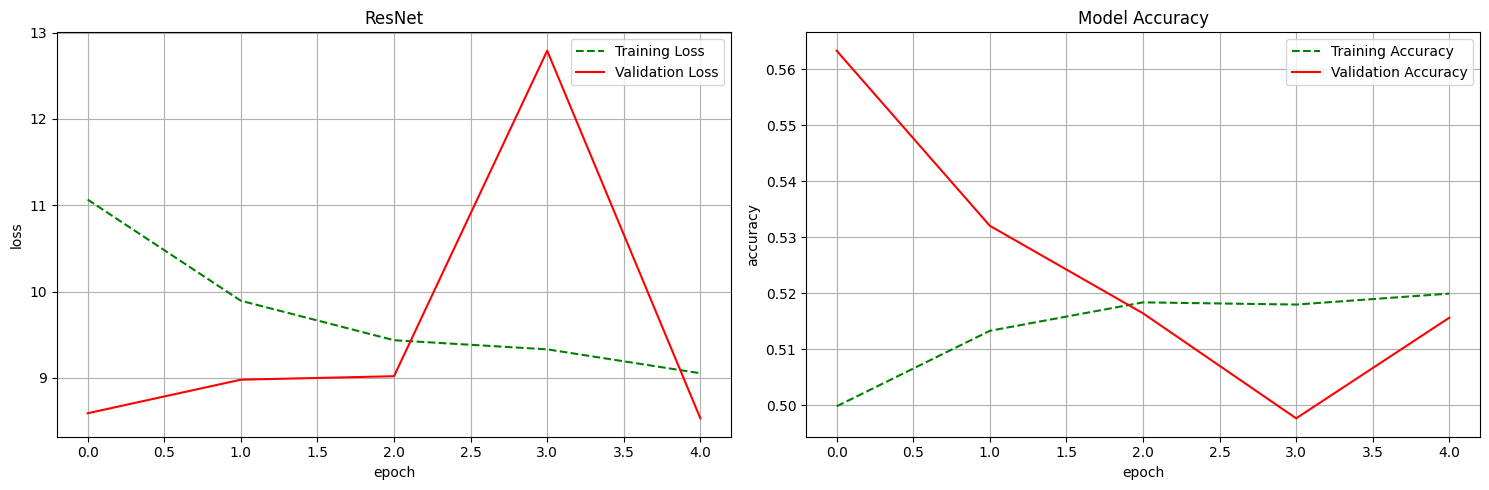

Epoch 5/49
----------


100%|██████████| 1280/1280 [03:32<00:00,  6.03it/s]


train Loss: 8.8690 Acc: 0.5289 MMSE Loss: 15.3947 CDR Loss: 0.3800


100%|██████████| 320/320 [00:18<00:00, 17.73it/s]


val Loss: 7.6962 Acc: 0.5984 MMSE Loss: 13.2889 CDR Loss: 0.3197
Epoch 6/49
----------


100%|██████████| 1280/1280 [03:32<00:00,  6.03it/s]


train Loss: 8.4169 Acc: 0.5354 MMSE Loss: 14.5418 CDR Loss: 0.3704


100%|██████████| 320/320 [00:18<00:00, 17.55it/s]


val Loss: 13.4261 Acc: 0.5578 MMSE Loss: 24.5206 CDR Loss: 0.3748
Epoch 7/49
----------


100%|██████████| 1280/1280 [03:32<00:00,  6.04it/s]


train Loss: 7.4812 Acc: 0.5832 MMSE Loss: 12.8531 CDR Loss: 0.3273


100%|██████████| 320/320 [00:17<00:00, 17.84it/s]


val Loss: 7.2817 Acc: 0.6047 MMSE Loss: 12.5574 CDR Loss: 0.3156
Epoch 8/49
----------


100%|██████████| 1280/1280 [03:32<00:00,  6.03it/s]


train Loss: 7.1742 Acc: 0.5943 MMSE Loss: 12.2734 CDR Loss: 0.3214


100%|██████████| 320/320 [00:17<00:00, 17.85it/s]


val Loss: 6.9462 Acc: 0.6133 MMSE Loss: 11.9038 CDR Loss: 0.3059
Epoch 9/49
----------


100%|██████████| 1280/1280 [03:32<00:00,  6.01it/s]


train Loss: 6.9589 Acc: 0.6004 MMSE Loss: 11.8794 CDR Loss: 0.3137


100%|██████████| 320/320 [00:17<00:00, 17.81it/s]


val Loss: 6.5898 Acc: 0.5820 MMSE Loss: 11.1790 CDR Loss: 0.3154


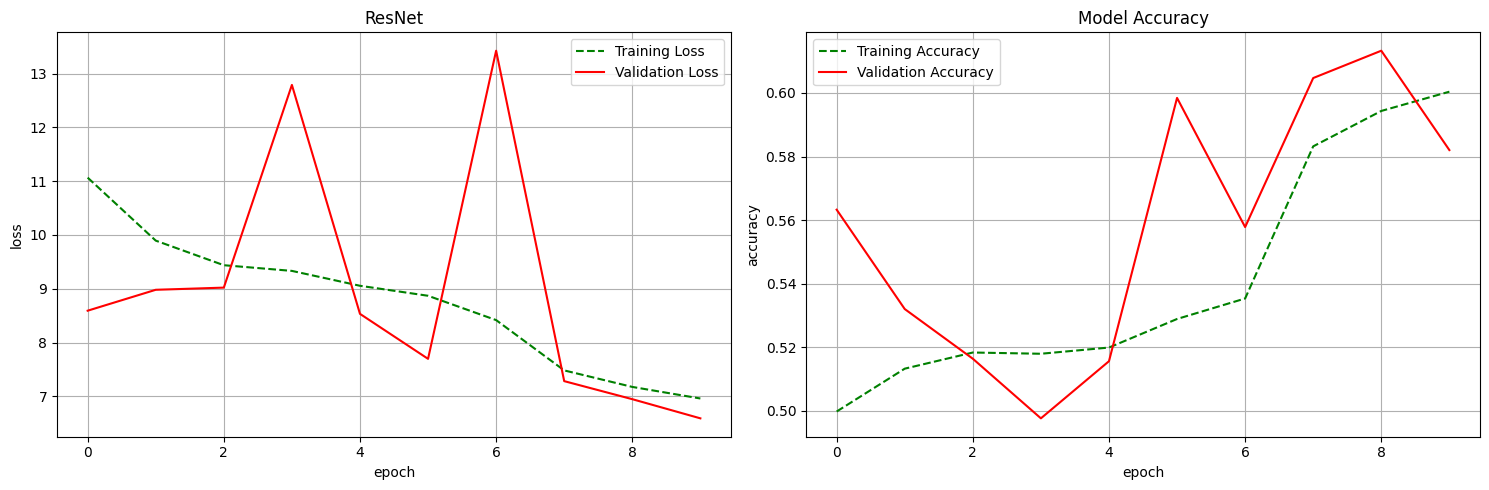

Epoch 10/49
----------


100%|██████████| 1280/1280 [03:32<00:00,  6.01it/s]


train Loss: 6.7412 Acc: 0.6086 MMSE Loss: 11.4810 CDR Loss: 0.3100


100%|██████████| 320/320 [00:17<00:00, 17.92it/s]


val Loss: 6.7227 Acc: 0.6148 MMSE Loss: 11.5246 CDR Loss: 0.3020
Epoch 11/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  6.01it/s]


train Loss: 6.5070 Acc: 0.6172 MMSE Loss: 11.0516 CDR Loss: 0.3016


100%|██████████| 320/320 [00:18<00:00, 17.60it/s]


val Loss: 7.6023 Acc: 0.6336 MMSE Loss: 13.3301 CDR Loss: 0.2719
Epoch 12/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  6.01it/s]


train Loss: 6.3740 Acc: 0.6350 MMSE Loss: 10.8511 CDR Loss: 0.2834


100%|██████████| 320/320 [00:17<00:00, 17.89it/s]


val Loss: 6.9157 Acc: 0.6234 MMSE Loss: 11.9180 CDR Loss: 0.3104
Epoch 13/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  6.00it/s]


train Loss: 6.2406 Acc: 0.6553 MMSE Loss: 10.6605 CDR Loss: 0.2710


100%|██████████| 320/320 [00:18<00:00, 17.52it/s]


val Loss: 7.9566 Acc: 0.5453 MMSE Loss: 13.6906 CDR Loss: 0.3965
Epoch 14/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.99it/s]


train Loss: 5.8474 Acc: 0.6801 MMSE Loss: 9.9623 CDR Loss: 0.2577


100%|██████████| 320/320 [00:17<00:00, 17.90it/s]


val Loss: 6.0884 Acc: 0.6656 MMSE Loss: 10.4418 CDR Loss: 0.2685


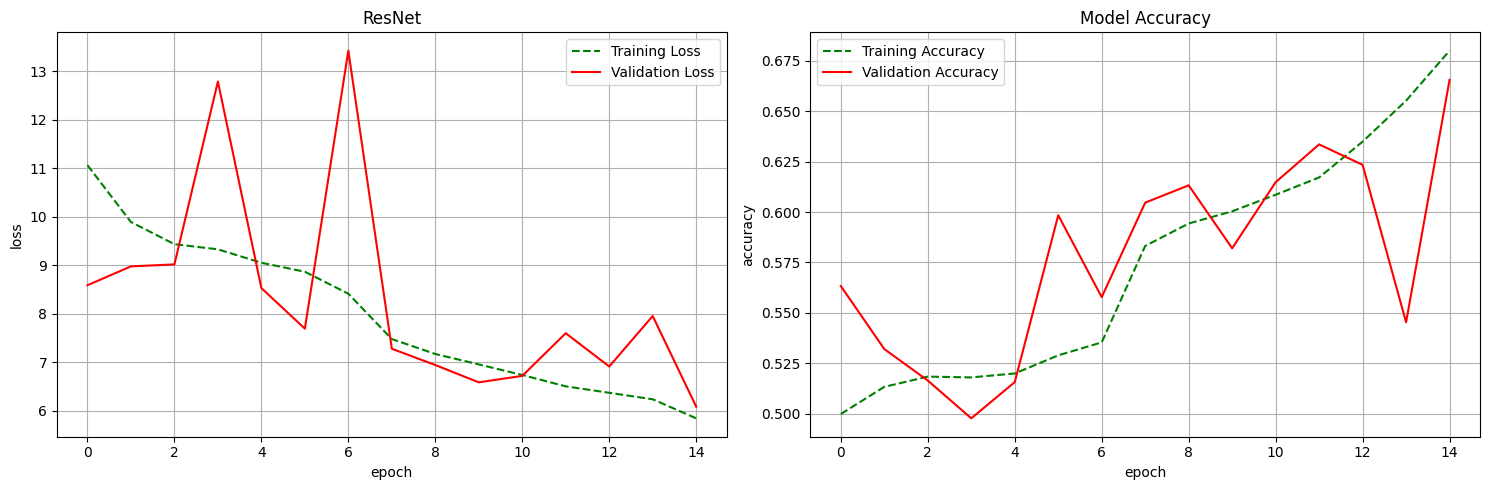

Epoch 15/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  6.00it/s]


train Loss: 5.7654 Acc: 0.6867 MMSE Loss: 9.8005 CDR Loss: 0.2622


100%|██████████| 320/320 [00:18<00:00, 17.71it/s]


val Loss: 5.9924 Acc: 0.6656 MMSE Loss: 10.2663 CDR Loss: 0.2546
Epoch 16/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.99it/s]


train Loss: 5.7794 Acc: 0.6887 MMSE Loss: 9.8487 CDR Loss: 0.2528


100%|██████████| 320/320 [00:18<00:00, 17.14it/s]


val Loss: 6.0448 Acc: 0.6727 MMSE Loss: 10.3806 CDR Loss: 0.2574
Epoch 17/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  6.01it/s]


train Loss: 5.7462 Acc: 0.6865 MMSE Loss: 9.8023 CDR Loss: 0.2420


100%|██████████| 320/320 [00:18<00:00, 17.57it/s]


val Loss: 6.1590 Acc: 0.6766 MMSE Loss: 10.6030 CDR Loss: 0.2701
Epoch 18/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.99it/s]


train Loss: 5.6293 Acc: 0.6938 MMSE Loss: 9.5778 CDR Loss: 0.2465


100%|██████████| 320/320 [00:18<00:00, 17.72it/s]


val Loss: 6.0063 Acc: 0.6766 MMSE Loss: 10.3244 CDR Loss: 0.2432
Epoch 19/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  6.00it/s]


train Loss: 5.7529 Acc: 0.6916 MMSE Loss: 9.7902 CDR Loss: 0.2571


100%|██████████| 320/320 [00:17<00:00, 17.80it/s]


val Loss: 6.0121 Acc: 0.6742 MMSE Loss: 10.3164 CDR Loss: 0.2737


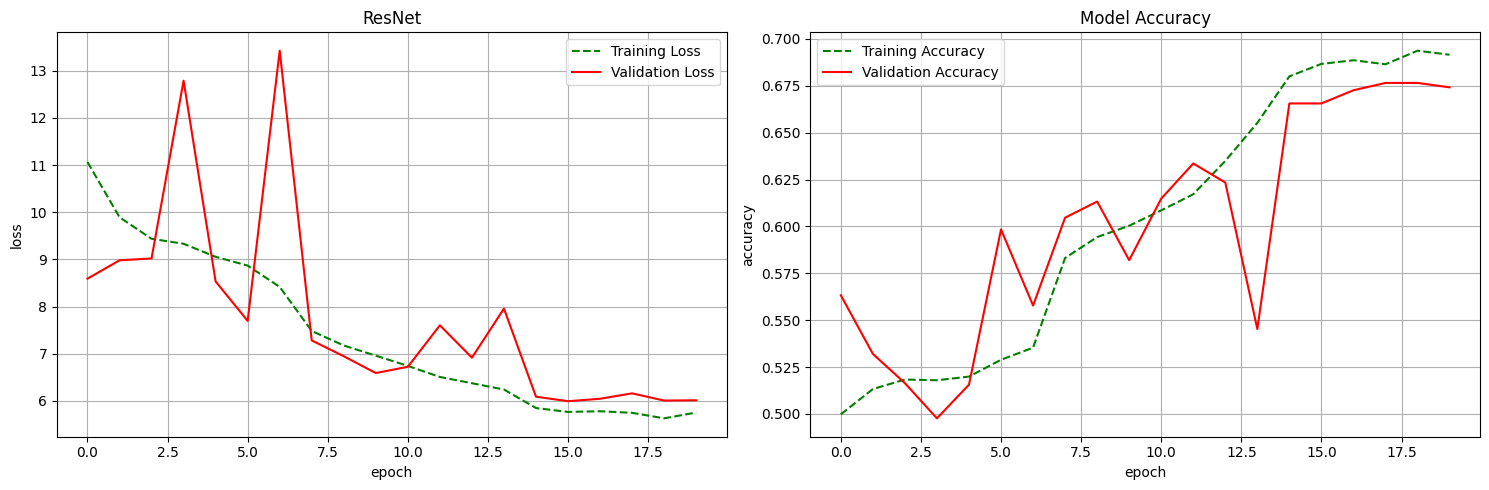

Epoch 20/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  6.00it/s]


train Loss: 5.6850 Acc: 0.6959 MMSE Loss: 9.6870 CDR Loss: 0.2537


100%|██████████| 320/320 [00:17<00:00, 17.80it/s]


val Loss: 6.1139 Acc: 0.6789 MMSE Loss: 10.5305 CDR Loss: 0.2648
Epoch 21/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.99it/s]


train Loss: 5.6088 Acc: 0.6951 MMSE Loss: 9.5401 CDR Loss: 0.2503


100%|██████████| 320/320 [00:18<00:00, 17.44it/s]


val Loss: 6.0047 Acc: 0.6797 MMSE Loss: 10.3002 CDR Loss: 0.2789
Epoch 22/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  6.00it/s]


train Loss: 5.7350 Acc: 0.6928 MMSE Loss: 9.7716 CDR Loss: 0.2648


100%|██████████| 320/320 [00:18<00:00, 17.69it/s]


val Loss: 5.9910 Acc: 0.6781 MMSE Loss: 10.2971 CDR Loss: 0.2537
Epoch 23/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.99it/s]


train Loss: 5.6388 Acc: 0.7010 MMSE Loss: 9.5993 CDR Loss: 0.2499


100%|██████████| 320/320 [00:18<00:00, 17.56it/s]


val Loss: 5.9171 Acc: 0.6773 MMSE Loss: 10.1188 CDR Loss: 0.2801
Epoch 24/49
----------


100%|██████████| 1280/1280 [03:34<00:00,  5.98it/s]


train Loss: 5.7457 Acc: 0.6920 MMSE Loss: 9.8099 CDR Loss: 0.2487


100%|██████████| 320/320 [00:17<00:00, 17.85it/s]


val Loss: 5.8989 Acc: 0.6789 MMSE Loss: 10.0955 CDR Loss: 0.2690


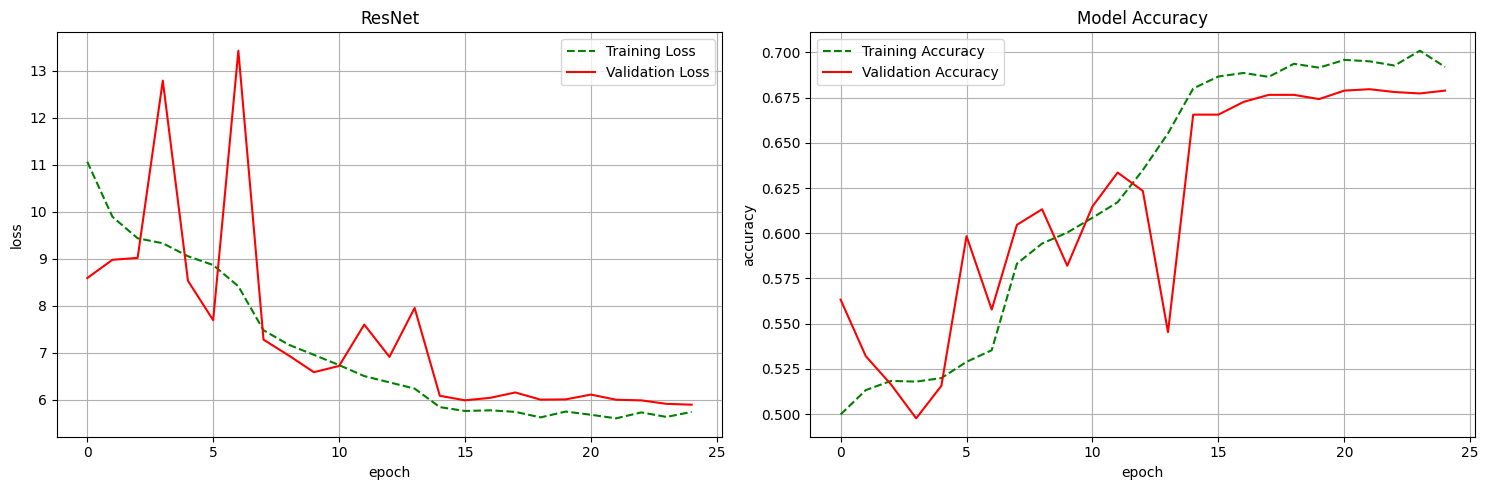

Epoch 25/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  6.00it/s]


train Loss: 5.4934 Acc: 0.6988 MMSE Loss: 9.3124 CDR Loss: 0.2498


100%|██████████| 320/320 [00:17<00:00, 17.95it/s]


val Loss: 5.9799 Acc: 0.6742 MMSE Loss: 10.2555 CDR Loss: 0.2736
Epoch 26/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.98it/s]


train Loss: 5.5316 Acc: 0.6945 MMSE Loss: 9.3879 CDR Loss: 0.2579


100%|██████████| 320/320 [00:18<00:00, 17.51it/s]


val Loss: 5.8915 Acc: 0.6797 MMSE Loss: 10.0854 CDR Loss: 0.2696
Epoch 27/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.98it/s]


train Loss: 5.5136 Acc: 0.7045 MMSE Loss: 9.3669 CDR Loss: 0.2480


100%|██████████| 320/320 [00:17<00:00, 17.86it/s]


val Loss: 5.9130 Acc: 0.6758 MMSE Loss: 10.1523 CDR Loss: 0.2474
Epoch 28/49
----------


100%|██████████| 1280/1280 [03:34<00:00,  5.98it/s]


train Loss: 5.5872 Acc: 0.7037 MMSE Loss: 9.5061 CDR Loss: 0.2564


100%|██████████| 320/320 [00:18<00:00, 17.16it/s]


val Loss: 5.9875 Acc: 0.6773 MMSE Loss: 10.2934 CDR Loss: 0.2529
Epoch 29/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.98it/s]


train Loss: 5.6269 Acc: 0.6928 MMSE Loss: 9.5800 CDR Loss: 0.2489


100%|██████████| 320/320 [00:17<00:00, 17.83it/s]


val Loss: 6.0702 Acc: 0.6828 MMSE Loss: 10.4629 CDR Loss: 0.2488


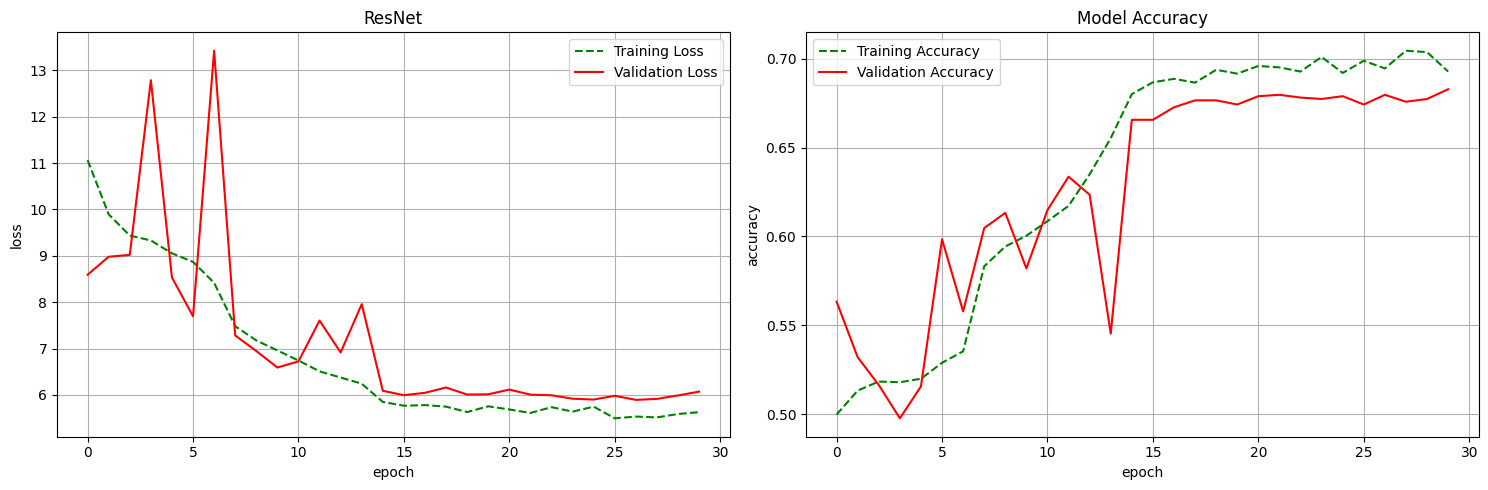

Epoch 30/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.99it/s]


train Loss: 5.4492 Acc: 0.7043 MMSE Loss: 9.2469 CDR Loss: 0.2471


100%|██████████| 320/320 [00:18<00:00, 17.51it/s]


val Loss: 6.0262 Acc: 0.6797 MMSE Loss: 10.3534 CDR Loss: 0.2709
Epoch 31/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.99it/s]


train Loss: 5.5467 Acc: 0.6971 MMSE Loss: 9.4101 CDR Loss: 0.2597


100%|██████████| 320/320 [00:17<00:00, 17.82it/s]


val Loss: 5.8686 Acc: 0.6766 MMSE Loss: 10.0703 CDR Loss: 0.2412
Epoch 32/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.98it/s]


train Loss: 5.6121 Acc: 0.7045 MMSE Loss: 9.5704 CDR Loss: 0.2443


100%|██████████| 320/320 [00:17<00:00, 17.82it/s]


val Loss: 5.9175 Acc: 0.6789 MMSE Loss: 10.1409 CDR Loss: 0.2637
Epoch 33/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.99it/s]


train Loss: 5.5711 Acc: 0.6973 MMSE Loss: 9.4809 CDR Loss: 0.2402


100%|██████████| 320/320 [00:18<00:00, 17.59it/s]


val Loss: 6.1151 Acc: 0.6773 MMSE Loss: 10.5497 CDR Loss: 0.2529
Epoch 34/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.99it/s]


train Loss: 5.4552 Acc: 0.6975 MMSE Loss: 9.2419 CDR Loss: 0.2515


100%|██████████| 320/320 [00:18<00:00, 17.75it/s]


val Loss: 5.8921 Acc: 0.6805 MMSE Loss: 10.1100 CDR Loss: 0.2467


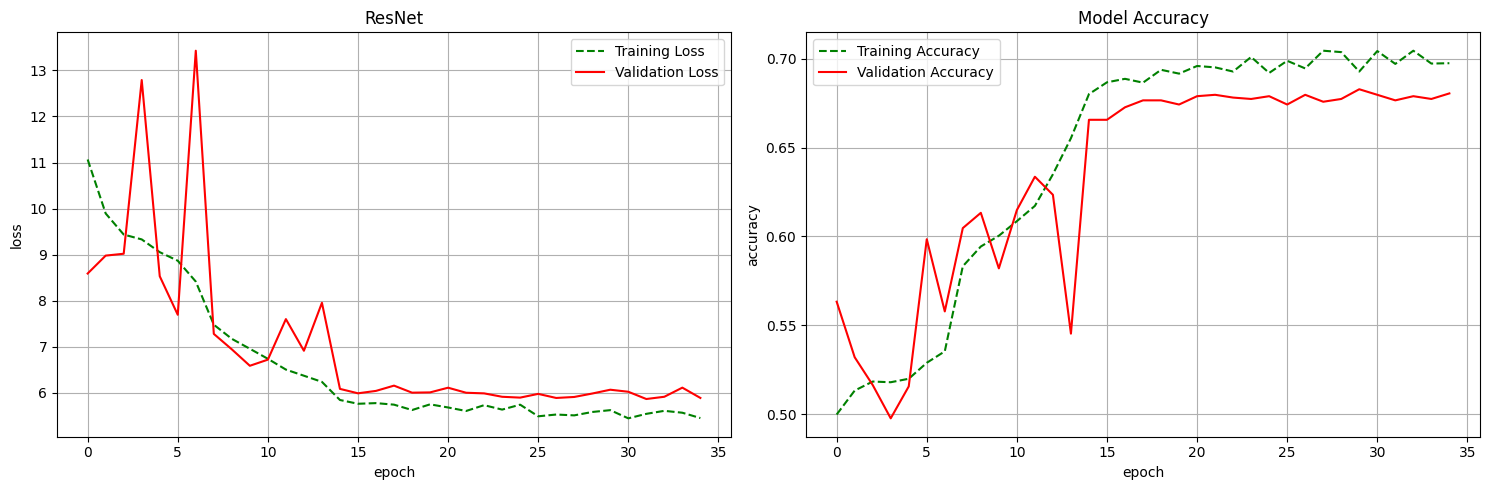

Epoch 35/49
----------


100%|██████████| 1280/1280 [03:34<00:00,  5.97it/s]


train Loss: 5.5848 Acc: 0.7041 MMSE Loss: 9.5170 CDR Loss: 0.2404


100%|██████████| 320/320 [00:18<00:00, 17.31it/s]


val Loss: 6.0807 Acc: 0.6844 MMSE Loss: 10.4692 CDR Loss: 0.2580
Epoch 36/49
----------


100%|██████████| 1280/1280 [03:34<00:00,  5.97it/s]


train Loss: 5.5838 Acc: 0.6934 MMSE Loss: 9.4761 CDR Loss: 0.2566


100%|██████████| 320/320 [00:18<00:00, 17.61it/s]


val Loss: 5.9159 Acc: 0.6742 MMSE Loss: 10.1445 CDR Loss: 0.2497
Epoch 37/49
----------


100%|██████████| 1280/1280 [03:33<00:00,  5.98it/s]


train Loss: 5.5300 Acc: 0.6967 MMSE Loss: 9.3870 CDR Loss: 0.2431


100%|██████████| 320/320 [00:18<00:00, 17.62it/s]


val Loss: 6.1313 Acc: 0.6781 MMSE Loss: 10.5808 CDR Loss: 0.2537
Epoch 38/49
----------


100%|██████████| 1280/1280 [03:34<00:00,  5.97it/s]


train Loss: 5.4770 Acc: 0.6977 MMSE Loss: 9.2901 CDR Loss: 0.2468


100%|██████████| 320/320 [00:18<00:00, 17.68it/s]


val Loss: 6.0180 Acc: 0.6836 MMSE Loss: 10.3443 CDR Loss: 0.2623
Epoch 39/49
----------


100%|██████████| 1280/1280 [03:34<00:00,  5.98it/s]


train Loss: 5.5467 Acc: 0.7025 MMSE Loss: 9.4247 CDR Loss: 0.2550


100%|██████████| 320/320 [00:18<00:00, 17.44it/s]


val Loss: 5.8706 Acc: 0.6773 MMSE Loss: 10.0685 CDR Loss: 0.2461


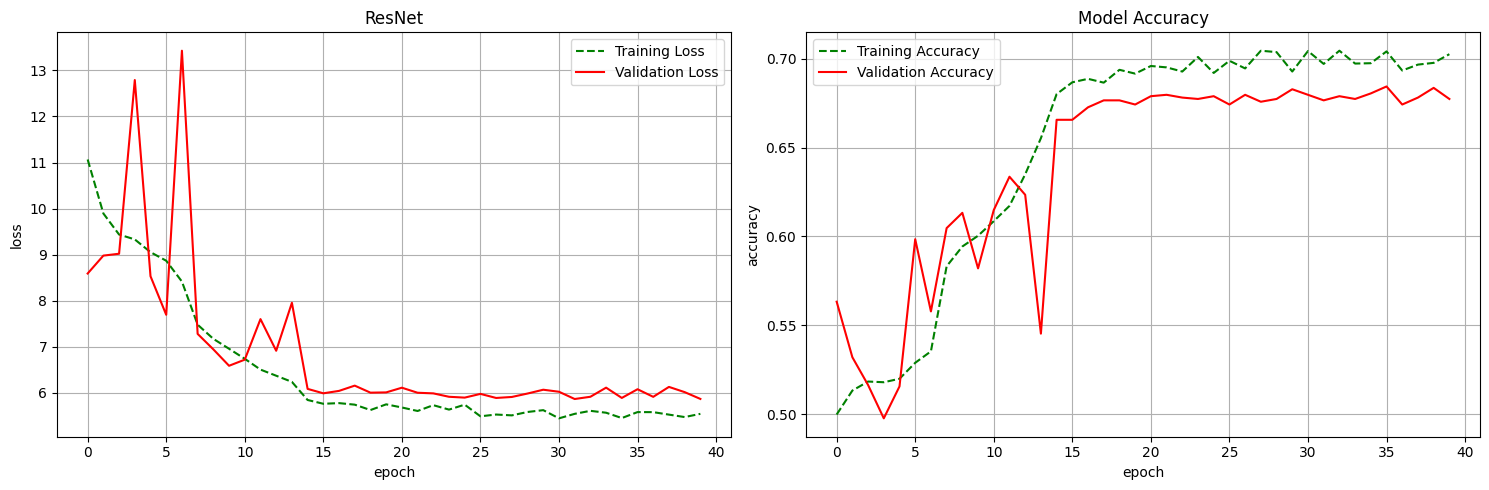

Epoch 40/49
----------


100%|██████████| 1280/1280 [03:34<00:00,  5.96it/s]


train Loss: 5.7371 Acc: 0.6900 MMSE Loss: 9.7910 CDR Loss: 0.2518


100%|██████████| 320/320 [00:18<00:00, 17.60it/s]


val Loss: 6.1006 Acc: 0.6766 MMSE Loss: 10.4968 CDR Loss: 0.2688
Epoch 41/49
----------


100%|██████████| 1280/1280 [03:34<00:00,  5.98it/s]


train Loss: 5.4893 Acc: 0.7035 MMSE Loss: 9.3100 CDR Loss: 0.2581


100%|██████████| 320/320 [00:18<00:00, 17.56it/s]


val Loss: 5.9569 Acc: 0.6805 MMSE Loss: 10.2239 CDR Loss: 0.2624
Epoch 42/49
----------


100%|██████████| 1280/1280 [03:34<00:00,  5.97it/s]


train Loss: 5.5718 Acc: 0.6990 MMSE Loss: 9.4718 CDR Loss: 0.2528


100%|██████████| 320/320 [00:18<00:00, 17.29it/s]


val Loss: 5.9121 Acc: 0.6781 MMSE Loss: 10.1142 CDR Loss: 0.2765
Epoch 43/49
----------


 13%|█▎        | 170/1280 [00:28<03:05,  5.97it/s]

In [ ]:
!pip install captum
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import nibabel as nib
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Add for visualization
import matplotlib.pyplot as plt
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz
import cv2

class BasicBlock2D(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock2D, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet2D(nn.Module):
    def __init__(self, block, num_blocks, in_channels=3, num_classes=4):
        super(ResNet2D, self).__init__()
        self.in_planes = 64

        # Initial convolution layer
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 512)

        # Multiple output heads
        self.classification_head = nn.Linear(512, num_classes)
        self.regression_mmse = nn.Linear(512, 1)  # MMSE score regression
        self.regression_cdr = nn.Linear(512, 1)   # Clinical Dementia Rating regression

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Input processing
        out = F.relu(self.bn1(self.conv1(x)))

        # ResNet blocks
        out1 = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)

        # Global pooling
        pooled = self.avgpool(out4)
        flat = pooled.view(pooled.size(0), -1)

        # Shared features
        features = F.relu(self.fc(flat))

        # Multi-task outputs
        classification = self.classification_head(features)
        mmse_score = self.regression_mmse(features)
        cdr_score = self.regression_cdr(features)

        # Store intermediate activations for visualization
        activations = {
            'layer1': out1,
            'layer2': out2,
            'layer3': out3,
            'layer4': out4
        }

        return {
            'classification': classification,
            'mmse_score': mmse_score,
            'cdr_score': cdr_score,
            'features': features,
            'activations': activations
        }

def ResNet18_2D(in_channels=3, num_classes=4):
    return ResNet2D(BasicBlock2D, [2, 2, 2, 2], in_channels, num_classes)

class BrainMRIDataset(Dataset):
    def __init__(self, data_dir, classes=['VeryMildDemented', 'MildDemented', 'NonDemented', 'ModerateDemented'], transform=None):
        """
        Dataset for multimodal brain MRI data

        Args:
            data_dir (str): Directory containing the data
            classes (list): List of class names
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.data_dir = data_dir
        self.classes = classes
        self.transform = transform

        # Find all images and labels
        self.images = []
        self.labels = []

        # Assuming directory structure: data_dir/class_label/image.png (or other image format)
        for class_idx, class_name in enumerate(classes):
            class_path = os.path.join(data_dir, class_name)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                self.images.append(image_path)
                self.labels.append(class_idx) # Assign class index as label

        print(f"Found {len(self.images)} images in total.")

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(image_path).convert('RGB')  # Convert to RGB if needed

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Simulate or load mmse_score and cdr_score (Replace with your actual logic)
        # Here I'm simulating them based on the label for demonstration purposes
        mmse_score = torch.tensor([28.0 if label == 2 else 20.0 + np.random.normal(0, 2)], dtype=torch.float32) # Assuming label 2 is 'NonDemented'
        cdr_score = torch.tensor([0.0 if label == 2 else 1.0 + np.random.normal(0, 0.5)], dtype=torch.float32)   # Assuming label 2 is 'NonDemented'

        # Extract subject ID from filename for visualization
        subject_id = os.path.basename(image_path).split('.')[0]

        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'mmse_score': mmse_score,
            'cdr_score': cdr_score,
            'subject_id': subject_id,
            'image_path': image_path  # Include image path for heatmap generation
        }

    def __len__(self):
        return len(self.images)

def train_model(model, dataloaders, criterion_dict, optimizer, scheduler, num_epochs=25, device='cuda'):
    """
    Train the model and record losses for visualization
    """
    model = model.to(device)
    best_acc = 0.0

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_mmse_loss = 0.0
            running_cdr_loss = 0.0

            # Iterate over data
            for inputs in tqdm(dataloaders[phase]):
                images = inputs['image'].to(device)
                labels = inputs['label'].to(device)
                mmse_scores = inputs['mmse_score'].to(device)
                cdr_scores = inputs['cdr_score'].to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    _, preds = torch.max(outputs['classification'], 1)

                    # Compute losses
                    classification_loss = criterion_dict['classification'](outputs['classification'], labels)
                    mmse_loss = criterion_dict['regression'](outputs['mmse_score'], mmse_scores)
                    cdr_loss = criterion_dict['regression'](outputs['cdr_score'], cdr_scores)

                    # Combined loss
                    loss = classification_loss + 0.5 * mmse_loss + 0.5 * cdr_loss

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_mmse_loss += mmse_loss.item() * images.size(0)
                running_cdr_loss += cdr_loss.item() * images.size(0)

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_mmse_loss = running_mmse_loss / len(dataloaders[phase].dataset)
            epoch_cdr_loss = running_cdr_loss / len(dataloaders[phase].dataset)

            # Store metrics for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} MMSE Loss: {epoch_mmse_loss:.4f} CDR Loss: {epoch_cdr_loss:.4f}')

            # Deep copy the model if it's the best validation accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()

        # Plot training progress every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            plot_training_progress(train_losses, val_losses, train_accs, val_accs)

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Save final loss plots
    plot_training_progress(train_losses, val_losses, train_accs, val_accs, save_path='final_training_plots.png')

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

def plot_training_progress(train_losses, val_losses, train_accs, val_accs, save_path=None):
    """
    Plot training and validation losses and accuracies
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, 'g--', label='Training Loss')
    ax1.plot(val_losses, 'r-', label='Validation Loss')
    ax1.set_title('ResNet')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accs, 'g--', label='Training Accuracy')
    ax2.plot(val_accs, 'r-', label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

def generate_heatmaps(model, dataloader, device='cuda', num_samples=5):
    """
    Generate heatmaps showing network activations for a few sample images
    """
    model.eval()
    model = model.to(device)

    # Get a batch of samples
    samples = next(iter(dataloader))
    images = samples['image'][:num_samples].to(device)
    labels = samples['label'][:num_samples].to(device)
    image_paths = samples['image_path'][:num_samples]

    # Get model outputs including activations
    with torch.no_grad():
        outputs = model(images)

    # Create figure for heatmaps
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, 3 * num_samples))

    for i in range(num_samples):
        # Original image
        orig_img = cv2.imread(image_paths[i])
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        orig_img = cv2.resize(orig_img, (224, 224))

        # Get activations for different layers
        layer1_act = outputs['activations']['layer1'][i].mean(dim=0).cpu().numpy()
        layer2_act = outputs['activations']['layer2'][i].mean(dim=0).cpu().numpy()
        layer3_act = outputs['activations']['layer3'][i].mean(dim=0).cpu().numpy()

        # Display images
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title('Original')

        # Display heatmaps - use jet colormap to match example
        im1 = axes[i, 1].imshow(layer1_act, cmap='jet')
        axes[i, 1].set_title('Layer1')

        im2 = axes[i, 2].imshow(layer2_act, cmap='jet')
        axes[i, 2].set_title('Layer2')

        im3 = axes[i, 3].imshow(layer3_act, cmap='jet')
        axes[i, 3].set_title('Layer3')

        # Add class label to original image title
        class_names = ['VeryMildDemented', 'MildDemented', 'NonDemented', 'ModerateDemented']
        axes[i, 0].set_title(f'Original - {class_names[labels[i]]}')

    plt.suptitle('Heat map of ResNet', fontsize=16)
    plt.tight_layout()
    plt.savefig('resnet_heatmaps.png')
    plt.show()

def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Set paths
    data_dir = "/content/drive/MyDrive/Alzheimer_MRI_4_classes_dataset"  # Update with your Google Drive path

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create dataset
    dataset = BrainMRIDataset(
        data_dir=data_dir,
        classes=['VeryMildDemented', 'MildDemented', 'NonDemented', 'ModerateDemented'],
        transform=transform
    )

    # Split into train and validation sets
    train_indices, val_indices = train_test_split(
        range(len(dataset)),
        test_size=0.2,
        random_state=42,
        stratify=dataset.labels
    )

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

    dataloaders = {
        'train': train_loader,
        'val': val_loader
    }

    # Create model
    model = ResNet18_2D(in_channels=3, num_classes=4)

    # Define loss functions
    criterion_dict = {
        'classification': nn.CrossEntropyLoss(),
        'regression': nn.MSELoss()
    }

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train model
    model, training_history = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion_dict=criterion_dict,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=50,  # Increased epochs to match the graphs
        device=device
    )

    # Save model
    torch.save(model.state_dict(), 'brain_mri_model.pth')

    # Generate heatmaps for a few samples
    generate_heatmaps(model, val_loader, device, num_samples=3)

    print("Training complete!")

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import random
import logging
from typing import List, Dict, Tuple

import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

class ResNetBlock(nn.Module):
    """Enhanced ResNet block with optional squeeze-and-excitation"""
    def __init__(self, in_planes, planes, stride=1, use_se=True):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        # Squeeze-and-Excitation
        self.use_se = use_se
        if use_se:
            self.se = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(planes, planes // 16, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(planes // 16, planes, kernel_size=1),
                nn.Sigmoid()
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.use_se:
            se_weights = self.se(out)
            out = out * se_weights

        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BrainMRIModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=4, block_type=ResNetBlock):
        super(BrainMRIModel, self).__init__()
        self.in_planes = 64

        # Initial layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers with residual blocks
        self.layer1 = self._make_layer(block_type, 64, 2, stride=1)
        self.layer2 = self._make_layer(block_type, 128, 2, stride=2)
        self.layer3 = self._make_layer(block_type, 256, 2, stride=2)
        self.layer4 = self._make_layer(block_type, 512, 2, stride=2)

        # Global pooling and feature extraction
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_extractor = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        # Multi-task heads
        self.classification_head = nn.Linear(256, num_classes)
        self.regression_heads = nn.ModuleDict({
            'mmse': nn.Linear(256, 1),
            'cdr': nn.Linear(256, 1)
        })

    def _make_layer(self, block_type, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for curr_stride in strides:
            layers.append(block_type(self.in_planes, planes, curr_stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(F.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = self.feature_extractor(x)

        return {
            'classification': self.classification_head(features),
            'mmse_score': self.regression_heads['mmse'](features),
            'cdr_score': self.regression_heads['cdr'](features),
            'features': features
        }

class BrainMRIDataset(Dataset):
    def __init__(self, data_dir: str, classes: List[str] = None, transform=None):
        """Enhanced dataset with more robust loading and metadata handling"""
        self.data_dir = data_dir
        self.classes = classes or ['VeryMildDemented', 'MildDemented', 'NonDemented', 'ModerateDemented']
        self.transform = transform or self._get_default_transforms()

        self.images = []
        self.labels = []
        self.metadata = []  # Optional: store additional metadata

        self._load_dataset()

    def _get_default_transforms(self):
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _load_dataset(self):
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.data_dir, class_name)
            for image_file in os.listdir(class_path):
                full_path = os.path.join(class_path, image_file)
                if os.path.isfile(full_path):
                    self.images.append(full_path)
                    self.labels.append(class_idx)
                    # Optional: Add metadata logic here

        logger.info(f"Loaded {len(self.images)} images across {len(self.classes)} classes")

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        # Simulated scores with more sophisticated generation
        noise = np.random.normal(0, 0.5)
        mmse_score = torch.tensor([max(0, min(30, 24 + noise * (label + 1)))], dtype=torch.float32)
        cdr_score = torch.tensor([max(0, min(3, 0.5 * label + noise))], dtype=torch.float32)

        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'mmse_score': mmse_score,
            'cdr_score': cdr_score
        }

    def __len__(self):
        return len(self.images)

def train_model(
    model: nn.Module,
    dataloaders: Dict[str, DataLoader],
    criterion_dict: Dict[str, nn.Module],
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    num_epochs: int = 50,
    device: str = 'cuda'
) -> Tuple[nn.Module, List[float], List[float]]:
    """Enhanced training function with early stopping and advanced logging"""
    model = model.to(device)
    best_val_loss = float('inf')
    patience = 10
    early_stopping_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, correct, total = 0.0, 0, 0

            with torch.set_grad_enabled(phase == 'train'):
                for batch in tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch+1}"):
                    images = batch['image'].to(device)
                    labels = batch['label'].to(device)
                    mmse_scores = batch['mmse_score'].to(device)
                    cdr_scores = batch['cdr_score'].to(device)

                    optimizer.zero_grad()
                    outputs = model(images)

                    class_loss = criterion_dict['classification'](outputs['classification'], labels)
                    mmse_loss = criterion_dict['regression'](outputs['mmse_score'], mmse_scores)
                    cdr_loss = criterion_dict['regression'](outputs['cdr_score'], cdr_scores)

                    # Weighted loss
                    loss = class_loss + 0.3 * mmse_loss + 0.3 * cdr_loss

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    _, predicted = torch.max(outputs['classification'], 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # Compute epoch metrics
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = correct / total

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                scheduler.step()
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # Early stopping
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    early_stopping_counter = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    early_stopping_counter += 1

                if early_stopping_counter >= patience:
                    logger.info(f"Early stopping triggered after {epoch+1} epochs")
                    break

        logger.info(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Val Loss {val_losses[-1]:.4f}")
        logger.info(f"Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    return model, train_accuracies, val_accuracies

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset and training configuration
    data_dir = "/path/to/Alzheimer_MRI_4_classes_dataset"

    # K-Fold Cross Validation
    dataset = BrainMRIDataset(data_dir)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset.images, dataset.labels), 1):
        logger.info(f"Training Fold {fold}")

        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

        dataloaders = {'train': train_loader, 'val': val_loader}

        model = BrainMRIModel(in_channels=3, num_classes=4)

        criterion_dict = {
            'classification': nn.CrossEntropyLoss(),
            'regression': nn.MSELoss()
        }

        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = CosineAnnealingLR(optimizer, T_max=50)

        model, train_acc, val_acc = train_model(
            model=model,
            dataloaders=dataloaders,
            criterion_dict=criterion_dict,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=50,
            device=device
        )

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/Alzheimer_MRI_4_classes_dataset/VeryMildDemented'